### Imports

In [103]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math
import pickle
import datetime

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize

from sklearn.model_selection import train_test_split
import tensorflow as tf

from scipy import ndimage
from skimage.morphology import reconstruction
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means


random_seed = 54321
np.random.seed(random_seed)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [104]:
tf.set_random_seed(random_seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

In [105]:
!nvidia-smi

Thu Dec 21 17:02:33 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P0    37W / 300W |   4690MiB / 16152MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Load Data

In [106]:
data = pd.read_json("Data/train/train.json", orient='records')
data.head()
train_df = data

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 75.2+ KB


### Missing values

In [108]:
train_df['inc_angle_f'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", train_df['inc_angle_f'].isnull().sum())
#train_df['inc_angle_f'].replace(np.nan,train_df['inc_angle_f'].mean(), inplace=True)
train_df['inc_angle_f'].replace(np.nan,0, inplace=True)
train_df.tail()

missing values in inc_angle:  133


,band_1,band_2,id,inc_angle,is_iceberg,inc_angle_f
1599,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",04e11240,na,0,0.0
1600,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",c7d6f6f8,na,0,0.0
1601,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",bba1a0f1,na,0,0.0
1602,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",7f66bb44,na,0,0.0
1603,"[-19.909191, -20.678406, -20.208834, -18.42441...","[-24.44487, -24.956001, -27.722103, -26.078417...",9d8f326c,na,0,0.0


### Transform for NN

In [109]:
def get_bands(train_df):
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

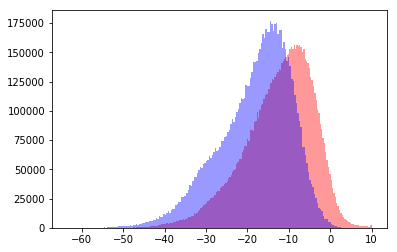

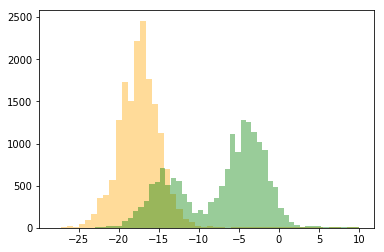

In [110]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4)
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index[:3]].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index[:3]].flatten(), bins=50, color="green", alpha=0.4)
plt.show()

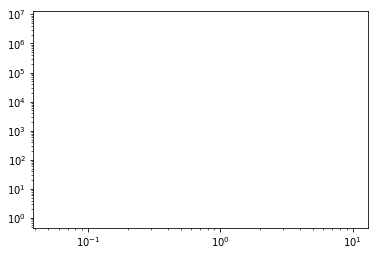

In [111]:
plt.hist(band_1_t.flatten(),bins=200, color="red", alpha=0.4)
plt.hist(band_2_t.flatten(),bins=200, color="blue", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

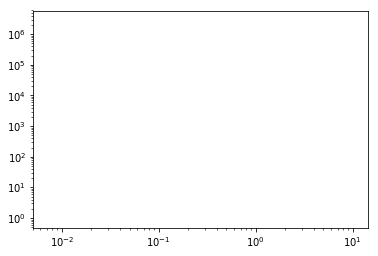

In [112]:
plt.hist(band_3[train_df[train_df['is_iceberg']==0].index].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_3[train_df[train_df['is_iceberg']==1].index].flatten(), bins=50, color="green", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

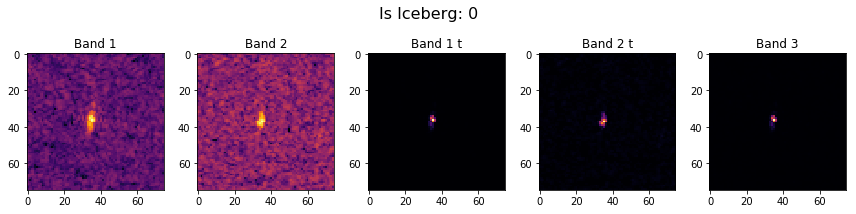

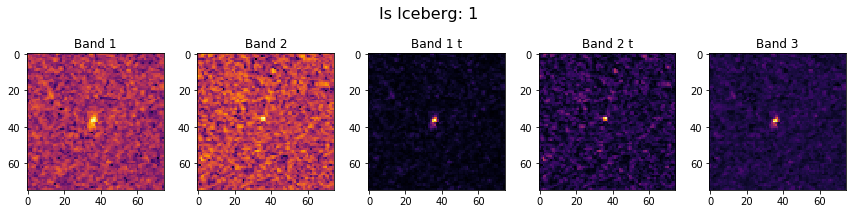

In [113]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")


In [114]:
y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle['index'] = y_angle.index

In [115]:
y_angle.head()

,is_iceberg,inc_angle_f,index
0,0,43.9239,0
1,0,38.1562,1
2,1,45.2859,2
3,0,43.8306,3
4,0,35.6256,4


### Split into train test and validation sets

In [116]:
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.3, random_state=random_seed)
print(X_train.shape)
print(X_val.shape)

(1122, 75, 75, 4)
(482, 75, 75, 4)


### Data augmentation

In [117]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                               temp_data[0][:,:,:,3],temp_band_3),axis=3)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)
        nn_denoised_temp = temp_data[0] #pass 4 bands for nn denoising input
        #denoised_temp = apply_over_axis(denoising, temp_stacked) #denoise all channels
        return [temp_stacked1, temp_stacked2, 
                nn_denoised_temp,
                #denoised_temp,
                temp_data[1][:,1]], temp_data[1][:,0]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)


(1122, 75, 75, 4)


### Denoising

In [118]:
def denoising(img):
    img_list = []
    for i in range(4):
        image = normalize(img[:,:,i])
        img_list.append(ndimage.median_filter(image, 3))
    return np.stack(img_list,axis=2)

In [119]:
def apply_over_axis(func, data, mask=None, axis=0, *args, **kwargs):
    f_list = []
    for i in range(data.shape[axis]):
        if mask is None:
            f_list.append(func(data[i], *args, **kwargs))
        else:
            f_list.append(func(data[i], mask=mask[i], *args, **kwargs))
    return np.stack(f_list,axis=0)

In [120]:
#X_denoised = apply_over_axis(denoising, X)

In [121]:
#index=8
#original_index = y_train_sample.iloc[index].name
#cmap="inferno"
#fig = plt.figure(figsize=(12,6))
#fig.suptitle("Denoising: is iceberg: %x" % (y_train_sample.iloc[index,0]), fontsize=16)
#ax1 = fig.add_subplot(251)
#ax1.set_title("Before")
#ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(252)
#ax2.set_title("Denoised")
#ax2.imshow(X_denoised[original_index][:,:,0], cmap=cmap)
#ax1 = fig.add_subplot(253)
#ax1.set_title("Before - band 2")
#ax1.imshow(X_train_sample[index][:,:,1], cmap=cmap)
#ax2 = fig.add_subplot(254)
#ax2.set_title("Denoised - band 2")
#ax2.imshow(X_denoised[original_index][:,:,1], cmap=cmap)
#plt.show()

### NN denoising

In [122]:
#custom generator for denoising
from collections import Generator
class Datagen_denoising(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                                temp_data[0][:,:,:,3]),axis=3)
        return temp_stacked, temp_stacked
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
        
datagen_denoising = Datagen_denoising(imagegen=datagen)
datagen_denoising_val = Datagen_denoising(imagegen=datagen_val)

In [123]:
m_input = Input(shape=(75,75,4), name='m_input')

#conv layers for main_input
x1 = BatchNormalization()(m_input)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
m_output = Conv2D(4, (3,3), activation='linear', name='m_output')(x1)
model_denoise = Model(inputs=[m_input,], outputs=[m_output], name='Model_nn_denoising')

model_denoise.compile(optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='mean_squared_error',
metrics=['mae'])

In [124]:
#model_denoise.summary()

In [125]:
#model training
start_time = time.monotonic()

H = model_denoise.fit_generator(datagen_denoising.flow(X, y_angle, batch_size=8),
                    steps_per_epoch=len(X)/8,
                    validation_data=datagen_denoising_val.flow(X, y_angle, batch_size=8, shuffle=False), 
                    validation_steps=len(X)/8,
                    #validation_data=[X_val,y_val],
                    epochs=10)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Epoch 1/10
201/200 [==============================] - 4s 20ms/step - loss: 18.7309 - mean_absolute_error: 2.3993 - val_loss: 14.8853 - val_mean_absolute_error: 2.2378
Epoch 2/10
201/200 [==============================] - 3s 14ms/step - loss: 11.8057 - mean_absolute_error: 1.9209 - val_loss: 12.9550 - val_mean_absolute_error: 2.0300
Epoch 3/10
201/200 [==============================] - 3s 14ms/step - loss: 12.5690 - mean_absolute_error: 1.9334 - val_loss: 15.2671 - val_mean_absolute_error: 2.3607
Epoch 4/10
201/200 [==============================] - 3s 14ms/step - loss: 11.9094 - mean_absolute_error: 1.9432 - val_loss: 2.6263 - val_mean_absolute_error: 1.0298
Epoch 5/10
201/200 [==============================] - 3s 14ms/step - loss: 9.3165 - mean_absolute_error: 1.7406 - val_loss: 12.8510 - val_mean_absolute_error: 1.9412
Epoch 6/10
201/200 [==============================] - 3s 14ms/step - loss: 9.2218 - mean_absolute_error: 1.7195 - val_loss: 4.2941 - val_mean_absolute_error: 1.2380
Ep

In [126]:
X_nn_denoised = model_denoise.predict(X, verbose=1)

1604/1604 [==============================] - 1s 390us/step


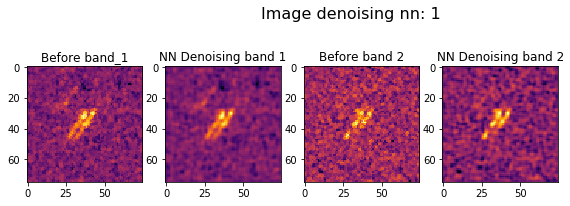

In [127]:
index=8
original_index = y_train_sample.iloc[index].name
cmap="inferno"
fig = plt.figure(figsize=(12,6))
fig.suptitle("Image denoising nn: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before band_1")
ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("NN Denoising band 1")
ax2.imshow(X_nn_denoised[original_index][:,:,0], cmap=cmap)
ax3 = fig.add_subplot(253)
ax3.set_title("Before band 2")
ax3.imshow(X_train_sample[index][:,:,1], cmap=cmap)
ax4 = fig.add_subplot(254)
ax4.set_title("NN Denoising band 2")
ax4.imshow(X_nn_denoised[original_index][:,:,1], cmap=cmap)
plt.show()

### Filtering regional maxima

In [128]:
#def img_filtering(img,mask,h=0.75):
#    img_list = []
#    for i in range(img.shape[2]):
#        image = img[:,:,i]
#        mask1 = mask[:,:,i]
#        h = (mask1.max() - mask1.min()) * h
#        seed = mask1 - h
#        dilated = reconstruction(seed, mask1, method='dilation')
#        hdome = image * dilated
#        img_list.append(hdome)
#    return np.stack(img_list,axis=2)
#
#def img_dilated(mask,h=0.2):
#    img_list = []
#    for i in range(mask.shape[2]):
#        mask1 = mask[:,:,i]
#        h = (mask1.max() - mask1.min()) * h
#        seed = mask1 - h
#        dilated = reconstruction(seed, mask1, method='dilation')
#        img_list.append(dilated)
#    return np.stack(img_list,axis=2)    

In [129]:
#X_filtered = apply_over_axis(img_filtering, X, mask=X_denoised)
#X_dilated = apply_over_axis(img_dilated, X_denoised )

In [130]:
#base_images = X_train_sample
#index=8
#original_index = y_train_sample.iloc[index].name
#cmap="inferno"
#fig = plt.figure(figsize=(14,6))
#fig.suptitle("Image filtering: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
#ax1 = fig.add_subplot(251)
#ax1.set_title("Before")
#ax1.imshow(base_images[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(252)
#ax2.set_title("Filtered")
#ax2.imshow(X_filtered[original_index][:,:,0], cmap=cmap)
#ax1 = fig.add_subplot(253)
#ax1.set_title("Before - band 2")
#ax1.imshow(base_images[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(254)
#ax2.set_title("Filtered - band 2")
#ax2.imshow(X_filtered[original_index][:,:,0], cmap=cmap)
#ax4 = fig.add_subplot(255)
#ax4.set_title("Dilated - band 1")
#ax4.imshow(X_dilated[original_index][:,:,0], cmap=cmap)
#plt.show()

### Keras model

In [131]:
model_code="CNN_2017_12_21_v1"
model_comment="2 CNN inputs 3,3 conv filters - nn denoising, na=0"

In [132]:
%%writefile current_model.py

def InputBlock(x, dropout=0.2, prefix=''):
    #conv layers for input
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    return(x)

main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')
#denoise_input = Input(shape=(75,75,4), name='denoise_input')
aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn')

x1 = InputBlock(main_input, prefix='m_input')
x2 = InputBlock(aux_input, prefix='a_input')
#x3 = InputBlock(denoise_input, prefix='d_input')
x3 = model_denoise(aux_input_nn)
x3 = InputBlock(x3,dropout=0.2, prefix='a_input_nn')

x = Concatenate(axis=3)([x1,x2,x3])
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#conv-block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#conv-block
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
#flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
#x1 = BatchNormalization()(angle_input)
merged = Concatenate()([x, angle_input])

#dense-block
x = Dense(513, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#dense-block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input, 
                        aux_input_nn,
                        #denoise_input,
                        angle_input], 
                        outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])

Overwriting current_model.py


In [133]:
%run -i current_model.py

In [143]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.66
    patience = 7.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

def step_decay2(epoch):
    initial_lrate = 0.000001
    drop = 0.66
    patience = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001):
        self.initial_lrate=initial_lrate

    def step_decay(epoch,logs):
        initial_lrate = self.initial_lrate
        drop = 0.66
        patience = 5.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

def get_callbacks(filepath, patience=10, step_decay=step_decay):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True, monitor = 'loss')
    #msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    lrScheduler = LearningRateScheduler(step_decay)
    return [msave, lrScheduler]

In [144]:
model_f.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
aux_input_nn (InputLayer)       (None, 75, 75, 4)    0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
Model_nn_denoising (Model)      (None, 75, 75, 4)    1252        aux_input_nn[0][0]               
__________________________________________________________________________________________________
batch_norm

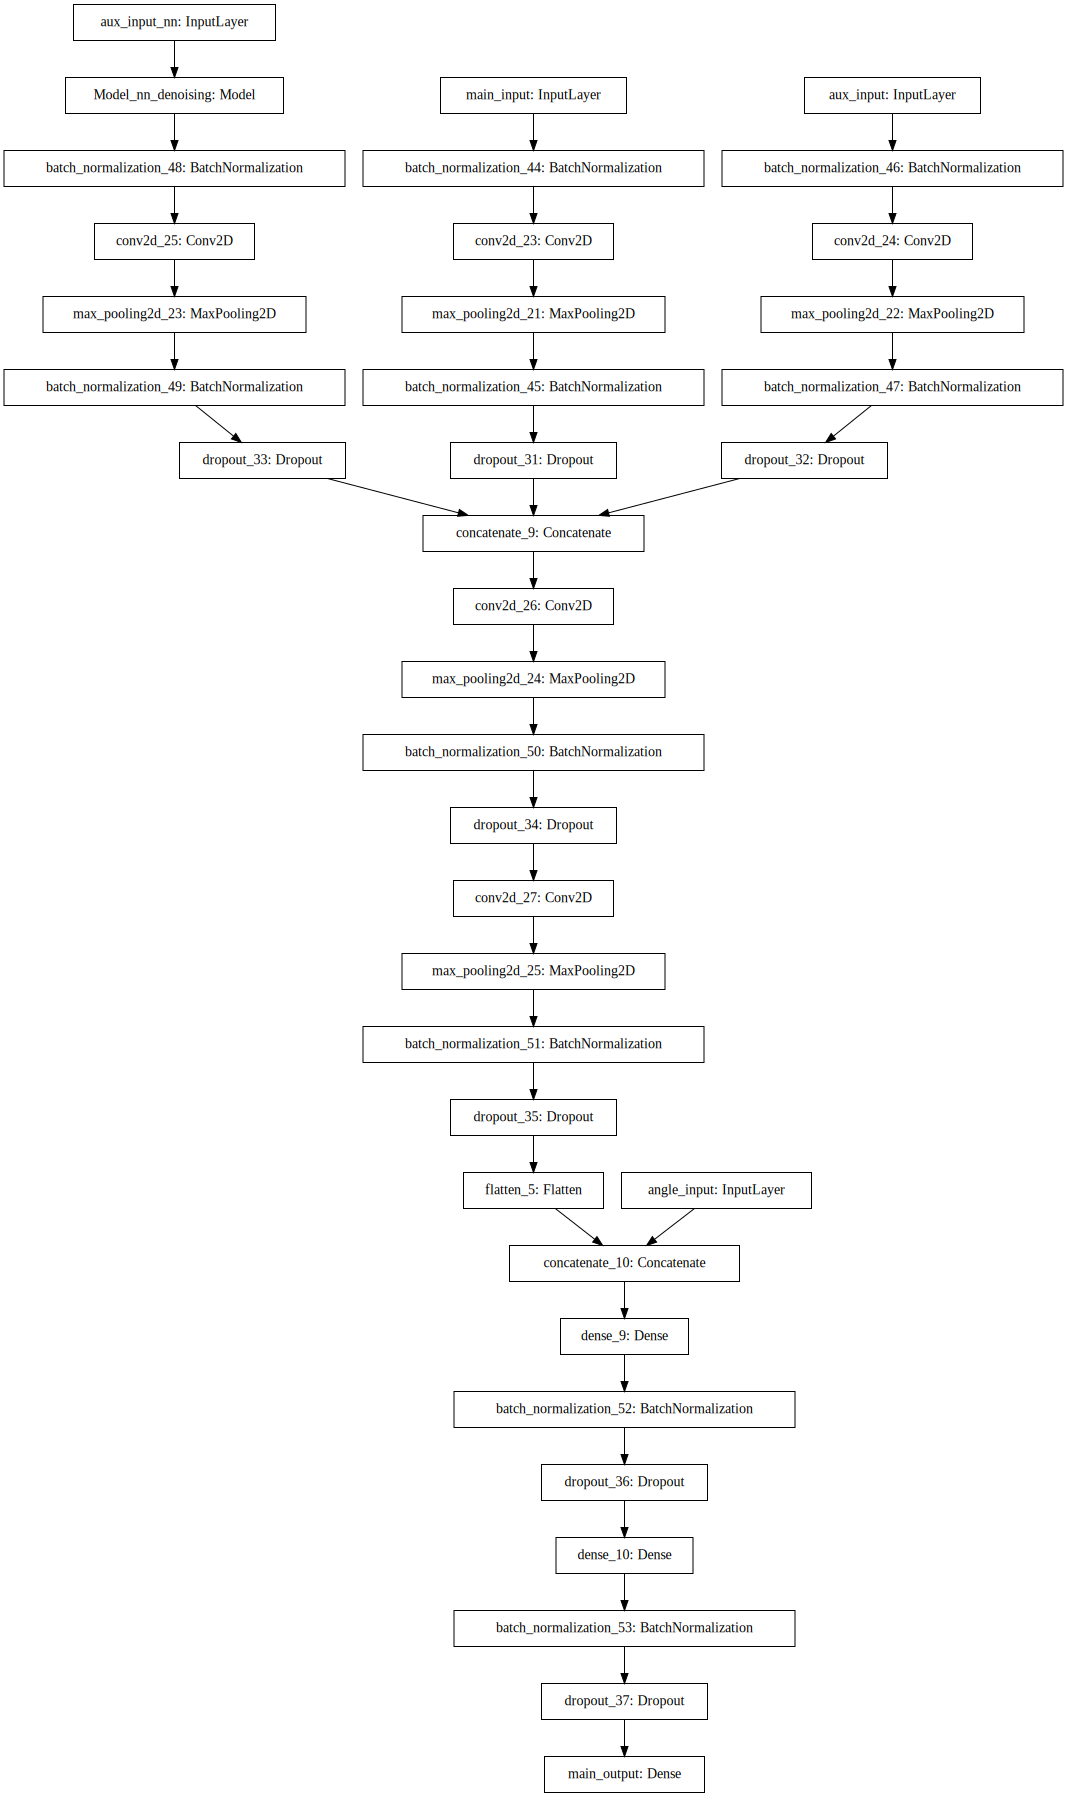

In [145]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#import os
#os.environ["PATH"] += os.pathsep + 'd:/Anaconda3/Library/bin/graphviz/'
SVG(model_to_dot(model_f).create(prog='dot', format='svg'))

### Model Training

In [146]:
#name init
model_timestamp = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model_best_weights_path = model_path + "weights." + model_code + "_" + model_timestamp + ".hdf5"
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay)

In [150]:
#model training
start_time = time.monotonic()

H = model_f.fit_generator(datagen_angle.flow(X, y_angle, batch_size=64),
                    steps_per_epoch=len(X)/64,
                    #validation_data=datagen_angle_val.flow(X, y_angle, batch_size=64, shuffle=False), 
                    #validation_steps=len(X)/32,
                    #validation_data=[X_val,y_val],
                    epochs=56, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  1e-06
Epoch 1/56
26/25 [===============================] - 3s 103ms/step - loss: 0.2151 - acc: 0.9098
Epoch 2/56
26/25 [===============================] - 2s 90ms/step - loss: 0.2231 - acc: 0.9149
Epoch 3/56
26/25 [===============================] - 2s 88ms/step - loss: 0.1972 - acc: 0.9080
Epoch 4/56
26/25 [===============================] - 2s 90ms/step - loss: 0.2143 - acc: 0.9032
Epoch 5/56
26/25 [===============================] - 2s 88ms/step - loss: 0.2391 - acc: 0.8981
Setting learning rate:  6.6e-07
Epoch 6/56
26/25 [===============================] - 3s 101ms/step - loss: 0.1701 - acc: 0.9302
Epoch 7/56
26/25 [===============================] - 3s 104ms/step - loss: 0.1717 - acc: 0.9263
Epoch 8/56
26/25 [===============================] - 2s 89ms/step - loss: 0.1772 - acc: 0.9332
Epoch 9/56
26/25 [===============================] - 2s 93ms/step - loss: 0.1649 - acc: 0.9362
Epoch 10/56
26/25 [===============================] - 2s 89ms/step - loss: 0.168

KeyError: 'val_loss'

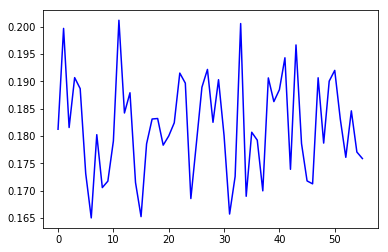

In [151]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [149]:
#addtional training epochs
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay2)
start_time = time.monotonic()

H2 = model_f.fit_generator(datagen_angle.flow(X, y_angle, batch_size=24),
                    steps_per_epoch=len(X)/24,
                    #validation_data=datagen_angle_val.flow(X, y_angle, batch_size=32, shuffle=False), 
                    #validation_steps=len(X)/12,
                    #validation_data=[X_val,y_val],
                    epochs=14, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  1e-06
Epoch 1/14
67/66 [==============================] - 3s 45ms/step - loss: 0.2365 - acc: 0.9045
Epoch 2/14
67/66 [==============================] - 2s 37ms/step - loss: 0.2414 - acc: 0.8996
Epoch 3/14
67/66 [==============================] - 3s 38ms/step - loss: 0.2426 - acc: 0.8889
Epoch 4/14
67/66 [==============================] - 3s 43ms/step - loss: 0.2192 - acc: 0.9175
Epoch 5/14
67/66 [==============================] - 2s 36ms/step - loss: 0.2368 - acc: 0.8990
Setting learning rate:  6.6e-07
Epoch 6/14
67/66 [==============================] - 3s 44ms/step - loss: 0.2171 - acc: 0.9108
Epoch 7/14
67/66 [==============================] - 2s 37ms/step - loss: 0.2348 - acc: 0.9072
Epoch 8/14
67/66 [==============================] - 2s 37ms/step - loss: 0.2438 - acc: 0.9016
Epoch 9/14
67/66 [==============================] - 3s 44ms/step - loss: 0.2133 - acc: 0.9203
Epoch 10/14
67/66 [==============================] - 2s 37ms/step - loss: 0.2334 - acc: 0.90

In [ ]:
for key in H.history:
    H.history[key].extend(H2.history[key])

In [ ]:
plt.plot(H2.history['loss'], color="b", label='Training loss')
plt.plot(H2.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [ ]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [ ]:
model_object_path = model_path + "model." + model_code + "_" + model_timestamp + '.hdf5'
model_f.save(model_object_path)
#model_f = load_model(model_object_path)

### Saving model history

In [ ]:
argmin = np.array(H.history["val_loss"]).argmin()
argmax_acc = np.array(H.history["val_acc"]).argmax()
with open('current_model.py','r') as model_python_code_file:
    models_history = pd.DataFrame({"timestamp":[model_timestamp], 
                                    "val_loss [min]":[H.history['val_loss'][argmin]],
                                    "epoch [val_loss [min]]":argmin,
                                    "training_loss [val_loss [min]]":[H.history['loss'][argmin]],
                                    "val_acc [val_loss [min]]":[H.history['val_acc'][argmin]],
                                    "training_acc [val_loss [min]]":[H.history['acc'][argmin]],
                                    
                                    "val_acc [max]":[H.history['val_acc'][argmax_acc]],
                                    "epoch [val_acc [max]]":argmax_acc,
                                    "training_loss [val_acc [max]]":[H.history['loss'][argmax_acc]],
                                    "val_loss [val_acc [max]]":[H.history['val_loss'][argmax_acc]],
                                    "training_acc [val_acc [max]]":[H.history['acc'][argmax_acc]],
                                    
                                    "model_path":[model_object_path],
                                    "model_weights_path":[model_best_weights_path],
                                    "model_python_code":[model_python_code_file.read().replace('\r\n','\n')],
                                    "model_comment":[model_comment]
                                })
                               
models_history = models_history[["timestamp", 
                                 "epoch [val_loss [min]]", "val_loss [min]", "training_loss [val_loss [min]]",
                                 "val_acc [val_loss [min]]", "training_acc [val_loss [min]]",
                                 "epoch [val_acc [max]]", "val_acc [max]", "training_loss [val_acc [max]]",
                                 "val_loss [val_acc [max]]", "training_acc [val_acc [max]]",
                                 "model_path","model_weights_path","model_python_code","model_comment"]]
models_history.head()

In [ ]:
print("Min validation loss epoch:")
print("epoch: %d" %(argmin),
      "; val loss [min] %.4f: " % (models_history["val_loss [min]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_loss [min]]"][0]),
      "; val acc: %.4f" % (models_history["val_acc [val_loss [min]]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_loss [min]]"][0])
     )
print("Max validation accuracy epoch:")
print("epoch: %d" %(argmax_acc),
      "; val loss %.4f: " % (models_history["val_loss [val_acc [max]]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_acc [max]]"][0]),
      "; val acc [max]: %.4f" % (models_history["val_acc [max]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_acc [max]]"][0]),
     )
print("model comment:", model_comment)


In [ ]:
with open('models_history.csv', 'a') as f:
    models_history.to_csv(f, header=False,index=False)
    #models_history.to_csv(f, index=False)

In [ ]:
df = pd.read_csv('models_history.csv')
df.tail()

### Predictions

In [152]:
model_f.load_weights(model_best_weights_path)

In [155]:
test_df = pd.read_json("Data/test/test.json")

In [156]:
test_df.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [157]:
test_df['inc_angle_f'] = pd.to_numeric(test_df['inc_angle'], errors='coerce')

print("missing values in inc_angle: ", test_df['inc_angle_f'].isnull().sum())

test_df['inc_angle_f'].replace(np.nan,0, inplace=True)

missing values in inc_angle:  0


In [158]:
t_band_1, t_band_2, t_band_1_t, t_band_2_t, t_band_3, X_test = get_bands(test_df)

y_angle_test = test_df.loc[:,['is_iceberg','inc_angle_f']]

y_angle_test['index'] = y_angle_test.index

current_model.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  #conv layers for input
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [159]:
predictions = model_f.predict_generator(datagen_angle_val.flow(X_test, y_angle_test, batch_size=32, shuffle=False),

                          steps = len(X_test)/31, verbose=1)

272/271 [==============================] - 3s 12ms/step


In [160]:
submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions[:8424].reshape(-1)})

submission.head(10)

,id,is_iceberg
0,5941774d,0.005288
1,4023181e,0.979689
2,b20200e4,0.000310
3,e7f018bb,0.998251
4,4371c8c3,0.933461
5,a8d9b1fd,0.059069
6,29e7727e,0.264501
7,92a51ffb,0.998842
8,c769ac97,0.005914
9,aee0547d,0.001500


In [161]:
submission.to_csv("submission_candidate_2.csv", index=False)